## importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
import pandas_profiling as pp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from time import time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Variable Definition


Variable               |      Definition
---|----
ID                    |Unique Identifier for a row
Gender                |Gender of the Customer
Age                  | Age of the Customer (in Years)
Region_Code           |Code of the Region for the customers
Occupation           | Occupation Type for the customer
Channel_Code         | Acquisition Channel Code for the Customer  (Encoded)
Vintage              | Vintage for the Customer (In Months)
Credit_Product       | If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
Avg_Account_Balance  | Average Account Balance for the Customer in last 12 Months
Is_Active            | If the Customer is Active in last 3 Months
Is_Lead(Target)       |If the Customer is interested for the Credit Card
_                      |0 : Customer is not interested
_                     |1 : Customer is interested



## Loading Datasets

In [2]:
train=pd.read_csv('train_s3TEQDk.csv')
train

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [3]:
test=pd.read_csv('test_mSzZ8RL.csv')

In [4]:
test.shape

(105312, 10)

## Data Inspection

In [5]:
print(train.isna().sum())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64


In [6]:
train['Credit_Product'].isna().sum()/train.shape[0]*100

11.9340726421813

In [7]:
test['Credit_Product'].isna().sum()/test.shape[0]

0.11890382862351868

### we observe that in Credit_Product column has 11.9% missed values in train as well as test

## Data Analysis

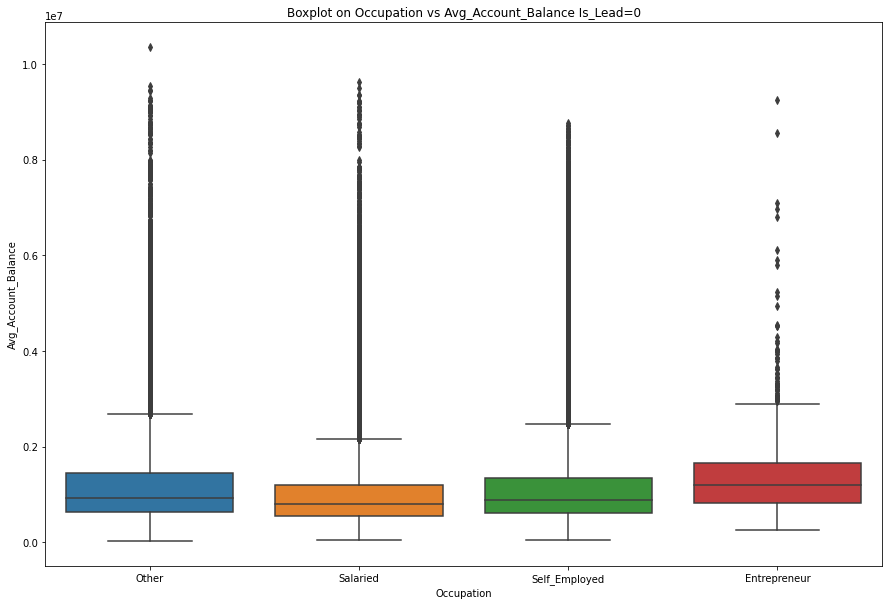

In [44]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Occupation',y='Avg_Account_Balance',data=train[train.Is_Lead==0]).set_title('Boxplot on Occupation vs Avg_Account_Balance Is_Lead=0')
plt.show()

## we observe that the Other,salaried,self_employed have same mean Avg_account_Balance Enterpreneur has some higher than remaining for non credit card holder

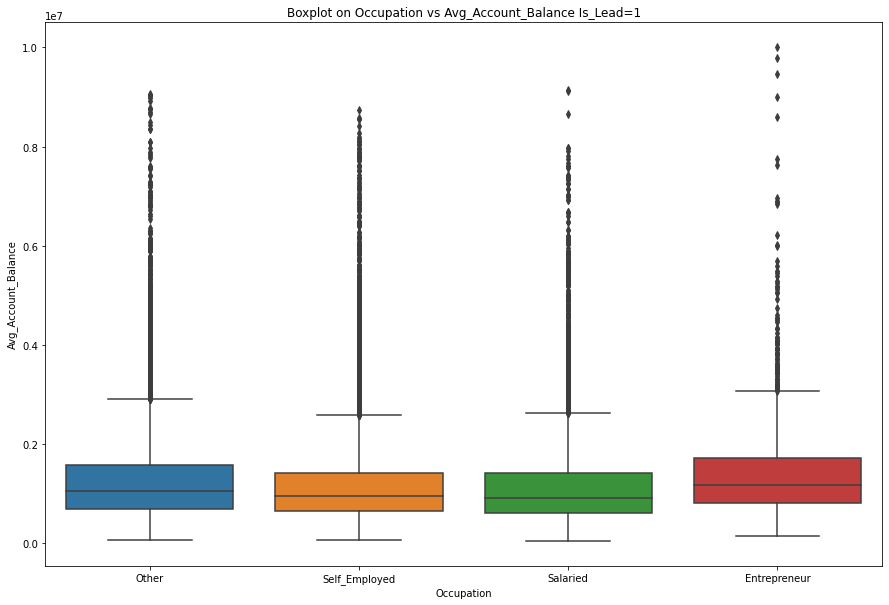

In [43]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Occupation',y='Avg_Account_Balance',data=train[train.Is_Lead==1]).set_title('Boxplot on Occupation vs Avg_Account_Balance Is_Lead=1')
plt.show()

## we observe that the Other,salaried,self_employed have same mean Avg_account_Balance Enterpreneur has some higher than remaining for credit card holder

## but the mean of credit card holder is high compared to non credit card holder

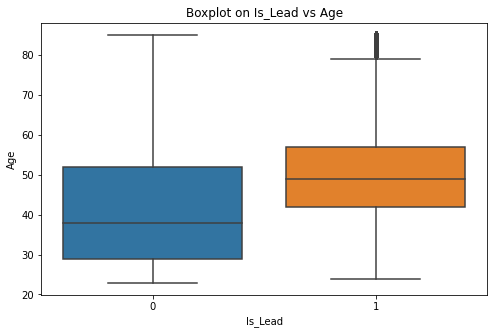

In [46]:
plt.figure(figsize=(8,5))    #setting Figure size
sns.boxplot(x='Is_Lead',y='Age',data=train).set_title('Boxplot on Is_Lead vs Age')
plt.show()

## Leads tend to be older as a result have more mean Age that non leads.

## if a person is older then there is high chances to take the Credit Card.

In [12]:
train[['Gender','Is_Lead']].value_counts()[train[['Gender','Is_Lead']].value_counts()>1]

Gender  Is_Lead
Male    0          98614
Female  0          88823
Male    1          35583
Female  1          22705
dtype: int64

## Our data is Imbalanced one.

In [13]:
train[['Gender','Avg_Account_Balance','Is_Lead']].value_counts()

Gender  Avg_Account_Balance  Is_Lead
Male    4022185              0          41
Female  4022185              0          40
Male    4022185              1          32
Female  2521592              0          15
        4022185              1          14
                                        ..
Male    734677               0           1
        734659               1           1
        734641               0           1
        734632               1           1
Female  45657                0           1
Length: 195981, dtype: int64

In [14]:
train[['Gender','Occupation','Is_Lead']].value_counts()

Gender  Occupation     Is_Lead
Male    Self_Employed  0          43054
Female  Salaried       0          34413
        Self_Employed  0          29991
Male    Other          0          28901
        Salaried       0          26090
Female  Other          0          24083
Male    Self_Employed  1          17210
        Other          1          10849
Female  Self_Employed  1          10631
Male    Salaried       1           6413
Female  Other          1           6340
        Salaried       1           5083
Male    Entrepreneur   1           1111
Female  Entrepreneur   1            651
Male    Entrepreneur   0            569
Female  Entrepreneur   0            336
dtype: int64

In [15]:
print(train[['Gender','Vintage','Is_Lead']].value_counts())

Gender  Vintage  Is_Lead
Female  21       0          5664
        13       0          5548
        19       0          5541
        20       0          5533
        15       0          5524
                            ... 
Male    134      0             4
Female  135      1             2
Male    133      1             2
        135      1             2
Female  133      1             1
Length: 263, dtype: int64


In [16]:
train['Avg_Account_Balance'].value_counts()

4022185    127
1611273     35
4126262     33
1142030     32
936814      31
          ... 
1016388      1
516680       1
1043017      1
784971       1
2760299      1
Name: Avg_Account_Balance, Length: 135292, dtype: int64

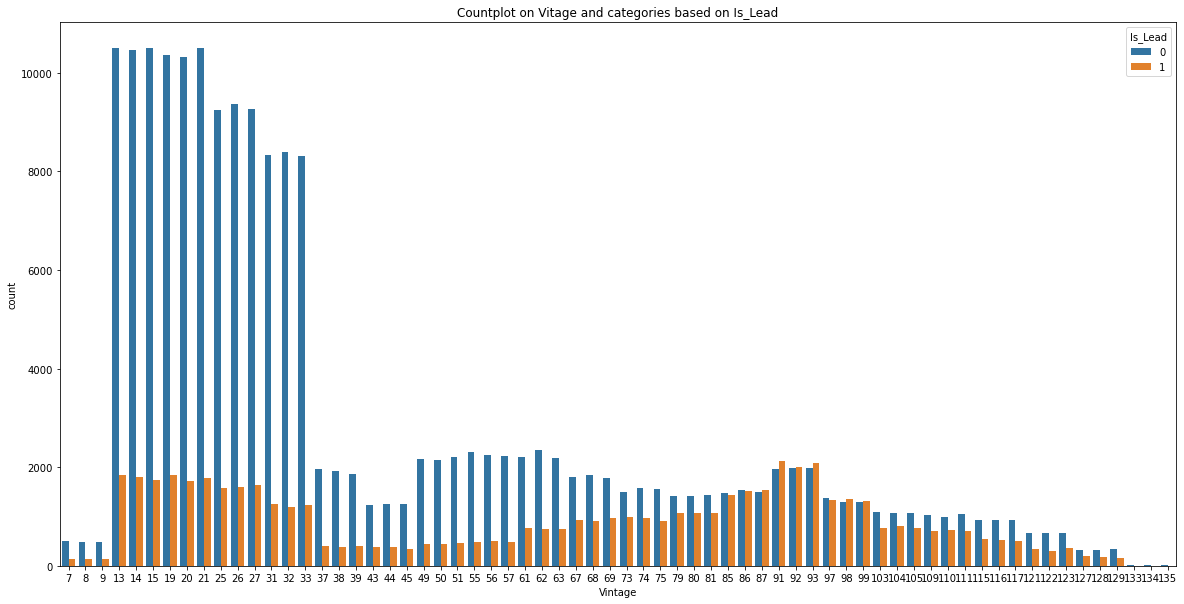

In [47]:
plt.figure(figsize=(20,10))
sns.countplot(x='Vintage',hue='Is_Lead',data=train).set_title('Countplot on Vitage and categories based on Is_Lead')
plt.show()

## 1)after using 90-100 months max percent want to interested in credit card products

## 2)and more account are oppended and used for 13-33months and in that range the customers are not interested in taking credit card is high than interesting in taking

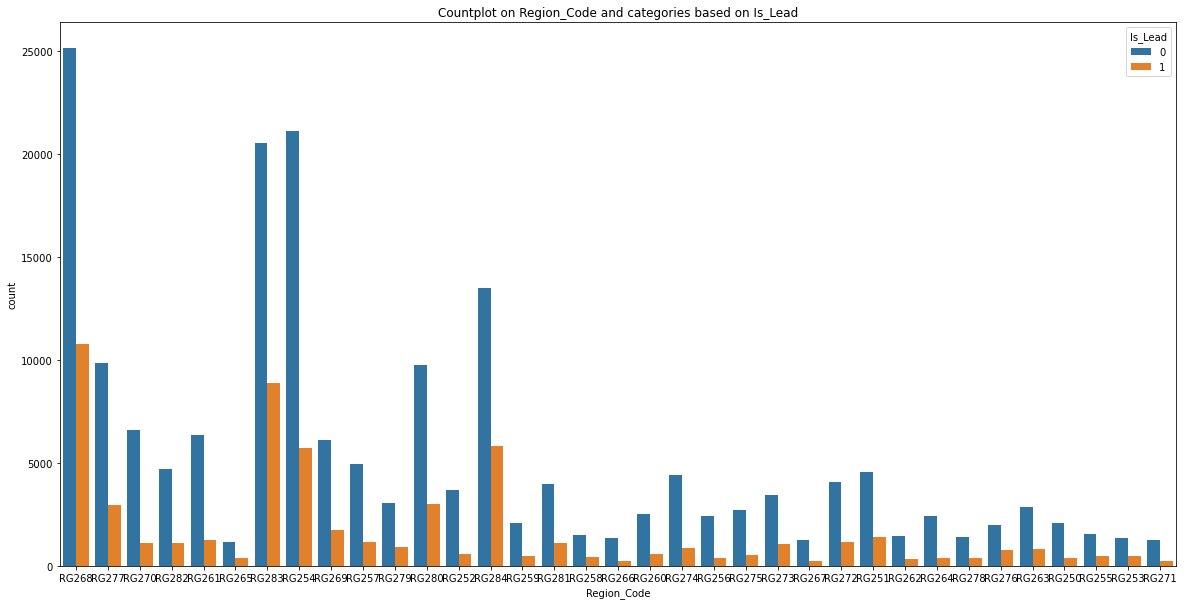

In [48]:
plt.figure(figsize=(20,10))
sns.countplot(x='Region_Code',hue='Is_Lead',data=train).set_title('Countplot on Region_Code and categories based on Is_Lead')
plt.show()

## Leads and Non Leads follow the same distribution.

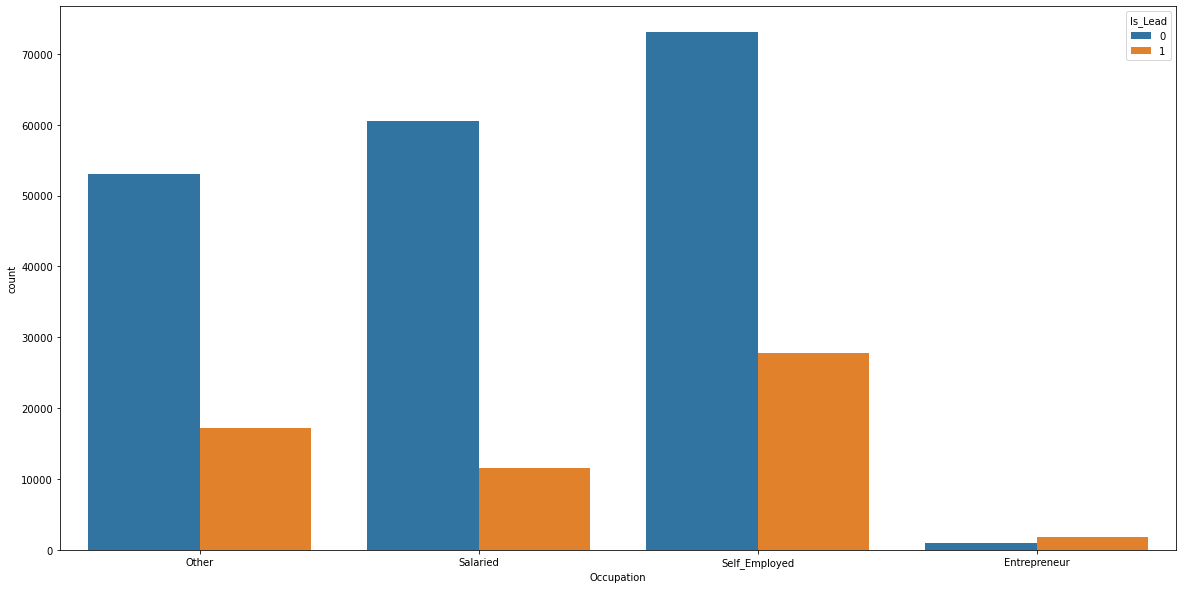

In [19]:
plt.figure(figsize=(20,10))
sns.countplot(x='Occupation',hue='Is_Lead',data=train)
plt.show()

## 1)Enterpreneurs are less in numbers but higher percent of Enterprenuers are interested in Credit Card
## 2)Self Employed are high in numbers 
## 3)Salaried persons are less interested in taking Credit Card

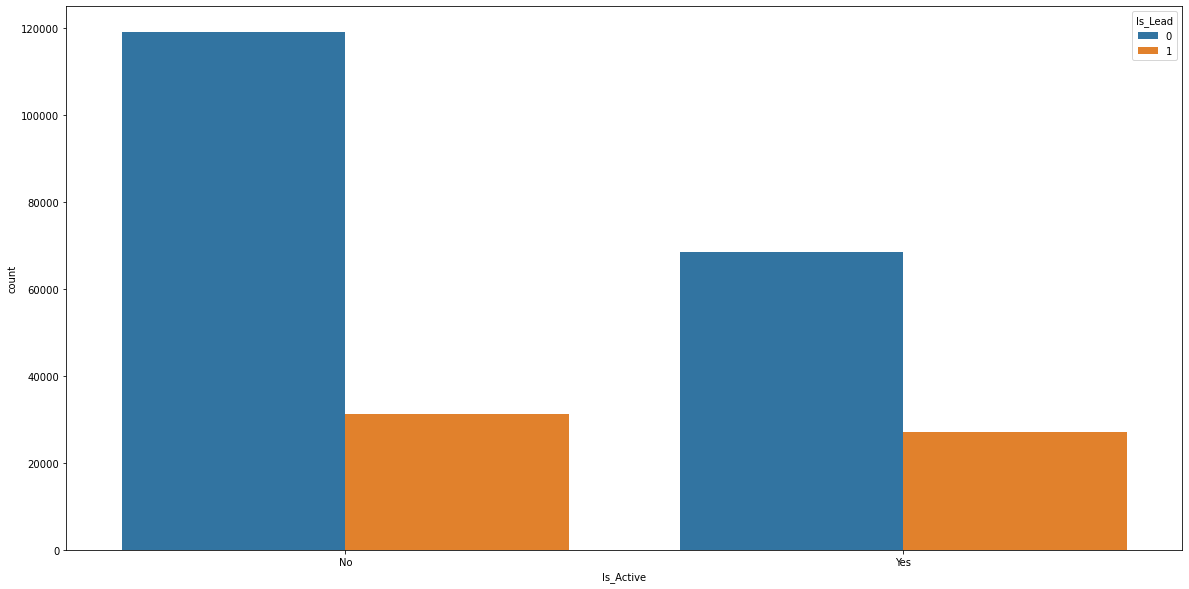

In [20]:
plt.figure(figsize=(20,10))
sns.countplot(x='Is_Active',hue='Is_Lead',data=train)
plt.show()

## 1)Most of the leads haven’t made a transaction in the last 3 months. 
## 2)Leads are evenly distributed in this regard.

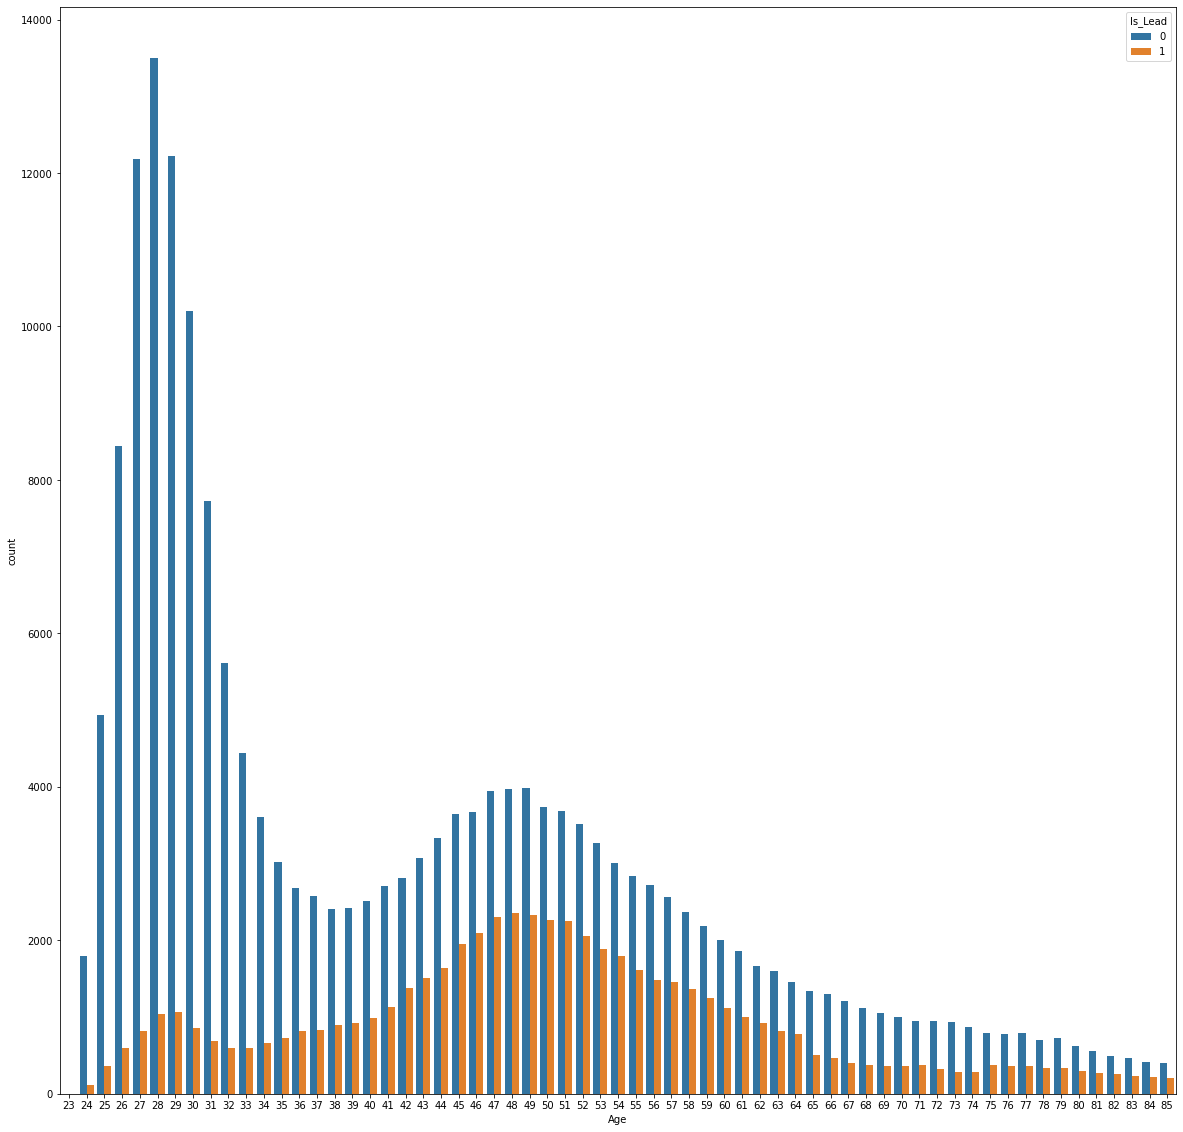

In [21]:
plt.figure(figsize=(20,20))
sns.countplot(x='Age',hue='Is_Lead',data=train)
plt.show()

## The chances of customer interest in taking credit card is high for age group between 45-55

## While the younger age group between 24-32 are not much interested in taking credit product 

## This age features help in solving the problem

<AxesSubplot:ylabel='Density'>

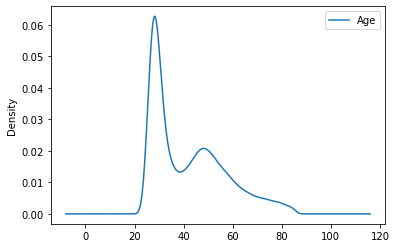

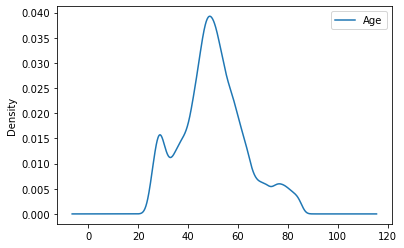

In [22]:
train[train.Is_Lead==0][['Age']].plot.kde()
train[train.Is_Lead==1][['Age']].plot.kde()

# Profiling using Pandas Profiling library it give more insites about the data

In [23]:
profile = pp.ProfileReport(train, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

## from the above doccument it give more insites from the distribution of data and its correlation and missing values.

## feature_engineering

In [24]:
X=train.drop(['Is_Lead','ID'],axis=1)
Y=train['Is_Lead']
Xt=test.drop(['ID'],axis=1)

In [25]:
clf=CountVectorizer() #calling CountVectorizer
gender_tr=clf.fit_transform(X['Gender']) #fit tranforming gender column 
gender_t=clf.transform(Xt['Gender'])     #tranforming gender column
gender_tr[:5].toarray()

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

In [26]:
clf1=CountVectorizer()  #calling CountVectorizer
Region_Code_tr=clf1.fit_transform(X['Region_Code']) #fit tranforming region
Region_Code_t=clf1.transform(Xt['Region_Code'])     #tranforming region
Region_Code_tr[:5].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [27]:
clf2=CountVectorizer()  #calling CountVectorizer
Occupation_tr=clf2.fit_transform(X['Occupation'])  #fit tranforming Occupation
Occupation_t=clf2.transform(Xt['Occupation'])      #tranforming Occupation
Occupation_tr[:5].toarray()

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [28]:
clf3=CountVectorizer()  #calling CountVectorizer
Channel_Code_tr=clf3.fit_transform(X['Channel_Code'])  #fit tranforming Channel Code
Channel_Code_t=clf3.transform(Xt['Channel_Code'])       #ranforming Channel Code
Channel_Code_tr[:5].toarray()

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [29]:
clf5=OneHotEncoder(drop='first')  #calling One hot encoding
Credit_Product_tr=clf5.fit_transform(X['Credit_Product'].fillna('NA').values.reshape(-1,1))  #fit tranforming Credit_Product
Credit_Product_t=clf5.transform(Xt['Credit_Product'].fillna('NA').values.reshape(-1,1))      #tranforming Credit_Product
Credit_Product_tr.toarray()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [30]:
clf6=CountVectorizer()  #calling CountVectorizer
Is_Active_tr=clf6.fit_transform(X['Is_Active'])   #fit tranforming Is_Active
Is_Active_t=clf6.transform(Xt['Is_Active'])      #tranforming Is_Active
Is_Active_tr[:5].toarray()

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]])

In [31]:
#adding features names to a list
features=[]
features.extend(clf.get_feature_names())
features.append('Age')
features.extend(clf1.get_feature_names())
features.extend(clf2.get_feature_names())
features.extend(clf3.get_feature_names())
# features.extend(clf4.get_feature_names())
features.append('Vintage')
features.extend(clf5.get_feature_names())
features.append('Avg_Account_Balance')
features.extend(clf6.get_feature_names())


## modeling part

In [32]:
#using hstack to get X for train and test
X_train=hstack((gender_tr,X['Age'].values.reshape(-1,1),Region_Code_tr,Occupation_tr,Channel_Code_tr,X['Vintage'].values.reshape(-1,1),Credit_Product_tr,X['Avg_Account_Balance'].values.reshape(-1,1),Is_Active_tr,)).tocsr()
X_test=hstack((gender_t,Xt['Age'].values.reshape(-1,1),Region_Code_t,Occupation_t,Channel_Code_t,Xt['Vintage'].values.reshape(-1,1),Credit_Product_t,Xt['Avg_Account_Balance'].values.reshape(-1,1),Is_Active_t,)).tocsr()

In [33]:
X_train,X_test

(<245725x52 sparse matrix of type '<class 'numpy.float64'>'
 	with 2182200 stored elements in Compressed Sparse Row format>,
 <105312x52 sparse matrix of type '<class 'numpy.float64'>'
 	with 935286 stored elements in Compressed Sparse Row format>)

In [34]:
start=time()   #starting time
adb=XGBClassifier()  #calling classifier
params={'n_estimators':[100,1000,1330],'learning_rate':[0.02,0.01,0.03]}   #giving parameters in a list
gsc1=GridSearchCV(adb,params,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)     
gsc1.fit(X_train,Y)  #applying gridsearch cv
print('total_time',time()-start)
pd.DataFrame(gsc1.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed: 29.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 34.0min finished
/home/kiran/anaconda3/envs/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
total_time 2188.149175643921


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.929943,0.077939,1.160091,0.178241,0.02,100,"{'learning_rate': 0.02, 'n_estimators': 100}",0.871409,0.872277,0.873728,0.872472,0.000957,7,0.875446,0.875295,0.874893,0.875211,0.000234
1,354.817510,0.109296,4.672237,0.272879,0.02,1000,"{'learning_rate': 0.02, 'n_estimators': 1000}",0.872232,0.872968,0.875069,0.873423,0.001202,3,0.890267,0.890756,0.890292,0.890438,0.000225
2,464.851514,2.779672,5.792534,0.167343,0.02,1330,"{'learning_rate': 0.02, 'n_estimators': 1330}",0.871898,0.872682,0.874722,0.873101,0.001190,5,0.893750,0.894291,0.893255,0.893766,0.000423
3,38.724555,0.706804,1.502532,0.039722,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.870254,0.871254,0.872772,0.871427,0.001035,9,0.873535,0.873765,0.873174,0.873491,0.000243
4,365.966297,5.206312,5.519193,0.531227,0.01,1000,"{'learning_rate': 0.01, 'n_estimators': 1000}",0.872791,0.873623,0.875418,0.873944,0.001096,1,0.884125,0.884359,0.883569,0.884018,0.000331
5,477.118652,3.854675,5.848463,0.056914,0.01,1330,"{'learning_rate': 0.01, 'n_estimators': 1330}",0.872603,0.873314,0.875355,0.873757,0.001167,2,0.886191,0.886781,0.885791,0.886254,0.000407
6,41.219853,2.055755,1.795274,0.199579,0.03,100,"{'learning_rate': 0.03, 'n_estimators': 100}",0.872257,0.873245,0.874459,0.873320,0.000901,4,0.877003,0.876774,0.876469,0.876749,0.000219
7,356.938324,2.115896,5.053631,0.613420,0.03,1000,"{'learning_rate': 0.03, 'n_estimators': 1000}",0.871536,0.872539,0.874409,0.872828,0.001190,6,0.895344,0.895747,0.895140,0.895410,0.000252
8,331.103134,75.194005,3.024898,1.223399,0.03,1330,"{'learning_rate': 0.03, 'n_estimators': 1330}",0.871053,0.872176,0.873928,0.872386,0.001183,8,0.899348,0.899754,0.898765,0.899289,0.000406


In [59]:
%%time
best_model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,    #using best parameters calling XGBoostClassifier
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=1330, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
best_model.fit(X_train,Y)        #training on data
calibration_clf=CalibratedClassifierCV(best_model,cv='prefit')   #calling calibratorclassifier to get probabilities
calibration_clf.fit(X_train,Y)         #calibrating on train
print(roc_auc_score(Y,calibration_clf.predict_proba(X_train)[:,1]))  #predicting probabilities
x_test_proba=calibration_clf.predict_proba(X_test)

/home/kiran/anaconda3/envs/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8881158073138561
CPU times: user 7min 22s, sys: 3.71 s, total: 7min 25s
Wall time: 1min 58s


/home/kiran/anaconda3/envs/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


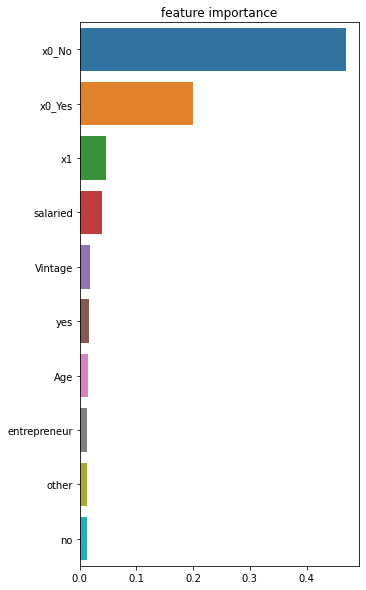

In [60]:
plt.figure(figsize=(5,10))
sns.barplot(best_model.feature_importances_[np.argsort(best_model.feature_importances_)[::-1]][:10],np.array(features)[np.argsort(best_model.feature_importances_)[::-1]][:10]).set_title('feature importance')
plt.show()

## validation

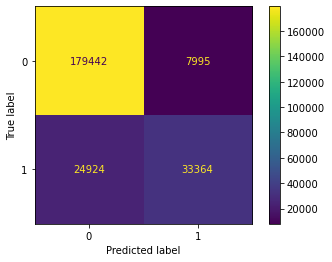

In [61]:
plot_confusion_matrix(calibration_clf,X_train,Y.values.reshape(-1,1))

In [62]:
roc_auc_score(Y,calibration_clf.predict_proba(X_train)[:,1])

0.8881158073138561

In [63]:
submission=pd.read_csv('sample_submission_eyYijxG.csv')
submission['Is_Lead']=best_model.predict_proba(X_test)[:,1]
submission.to_csv('my_submission.csv', index=False)